In [11]:
import numpy as np

embeddings_mnistTrain = np.loadtxt('siamese_embeddings/embed_mnistTrain.txt', delimiter=',')
embeddings_mnistTest = np.loadtxt('siamese_embeddings/embed_mnistTest.txt', delimiter=',')
embeddings_notMnistTest = np.loadtxt('siamese_embeddings/embed_notMnistTest.txt', delimiter=',')
print(embeddings_mnistTrain.shape, embeddings_mnistTest.shape, embeddings_notMnistTest.shape)

(55000, 2) (10000, 2) (10000, 2)


In [13]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data')
y_train = mnist.train.labels

print(y_train.shape)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
(55000,)


# Distribution modeling

In [16]:
from scipy.stats import norm
from scipy.stats import multivariate_normal
import pprint

# model X, Y, as bivariate dist
params = {}

for i in range(10):
    class_data = np.array([embeddings_mnistTrain[:, 0][y_train == i],
                           embeddings_mnistTrain[:, 1][y_train == i]])
    mean = np.mean(class_data, axis=1)
    cov = np.cov(class_data)
    params[i] = {'mean': mean, 'cov': cov}

# print mean, covariances for each distribution
pp = pprint.PrettyPrinter()
pp.pprint(params)

{0: {'cov': array([[ 0.13590884,  0.09036265],
       [ 0.09036265,  0.18033643]]),
     'mean': array([ 3.40548917,  8.46703284])},
 1: {'cov': array([[ 0.1302544 ,  0.0040155 ],
       [ 0.0040155 ,  0.06201917]]),
     'mean': array([-8.44334309, -0.60486406])},
 2: {'cov': array([[ 0.18459897, -0.01492765],
       [-0.01492765,  0.11459112]]),
     'mean': array([-6.98215893,  4.88289231])},
 3: {'cov': array([[ 0.17144894, -0.0259684 ],
       [-0.0259684 ,  0.14128297]]),
     'mean': array([-2.1753381 ,  7.16792601])},
 4: {'cov': array([[ 0.08955853,  0.01747651],
       [ 0.01747651,  0.12852833]]),
     'mean': array([ 1.13750357, -4.8119656 ])},
 5: {'cov': array([[ 0.11507251,  0.01272883],
       [ 0.01272883,  0.1825792 ]]),
     'mean': array([ 1.46829426,  3.07159354])},
 6: {'cov': array([[ 0.09268209,  0.03146844],
       [ 0.03146844,  0.12697598]]),
     'mean': array([-4.24002247, -4.46999377])},
 7: {'cov': array([[ 0.15130525,  0.05349149],
       [ 0.05349149,  

(90000, 2)


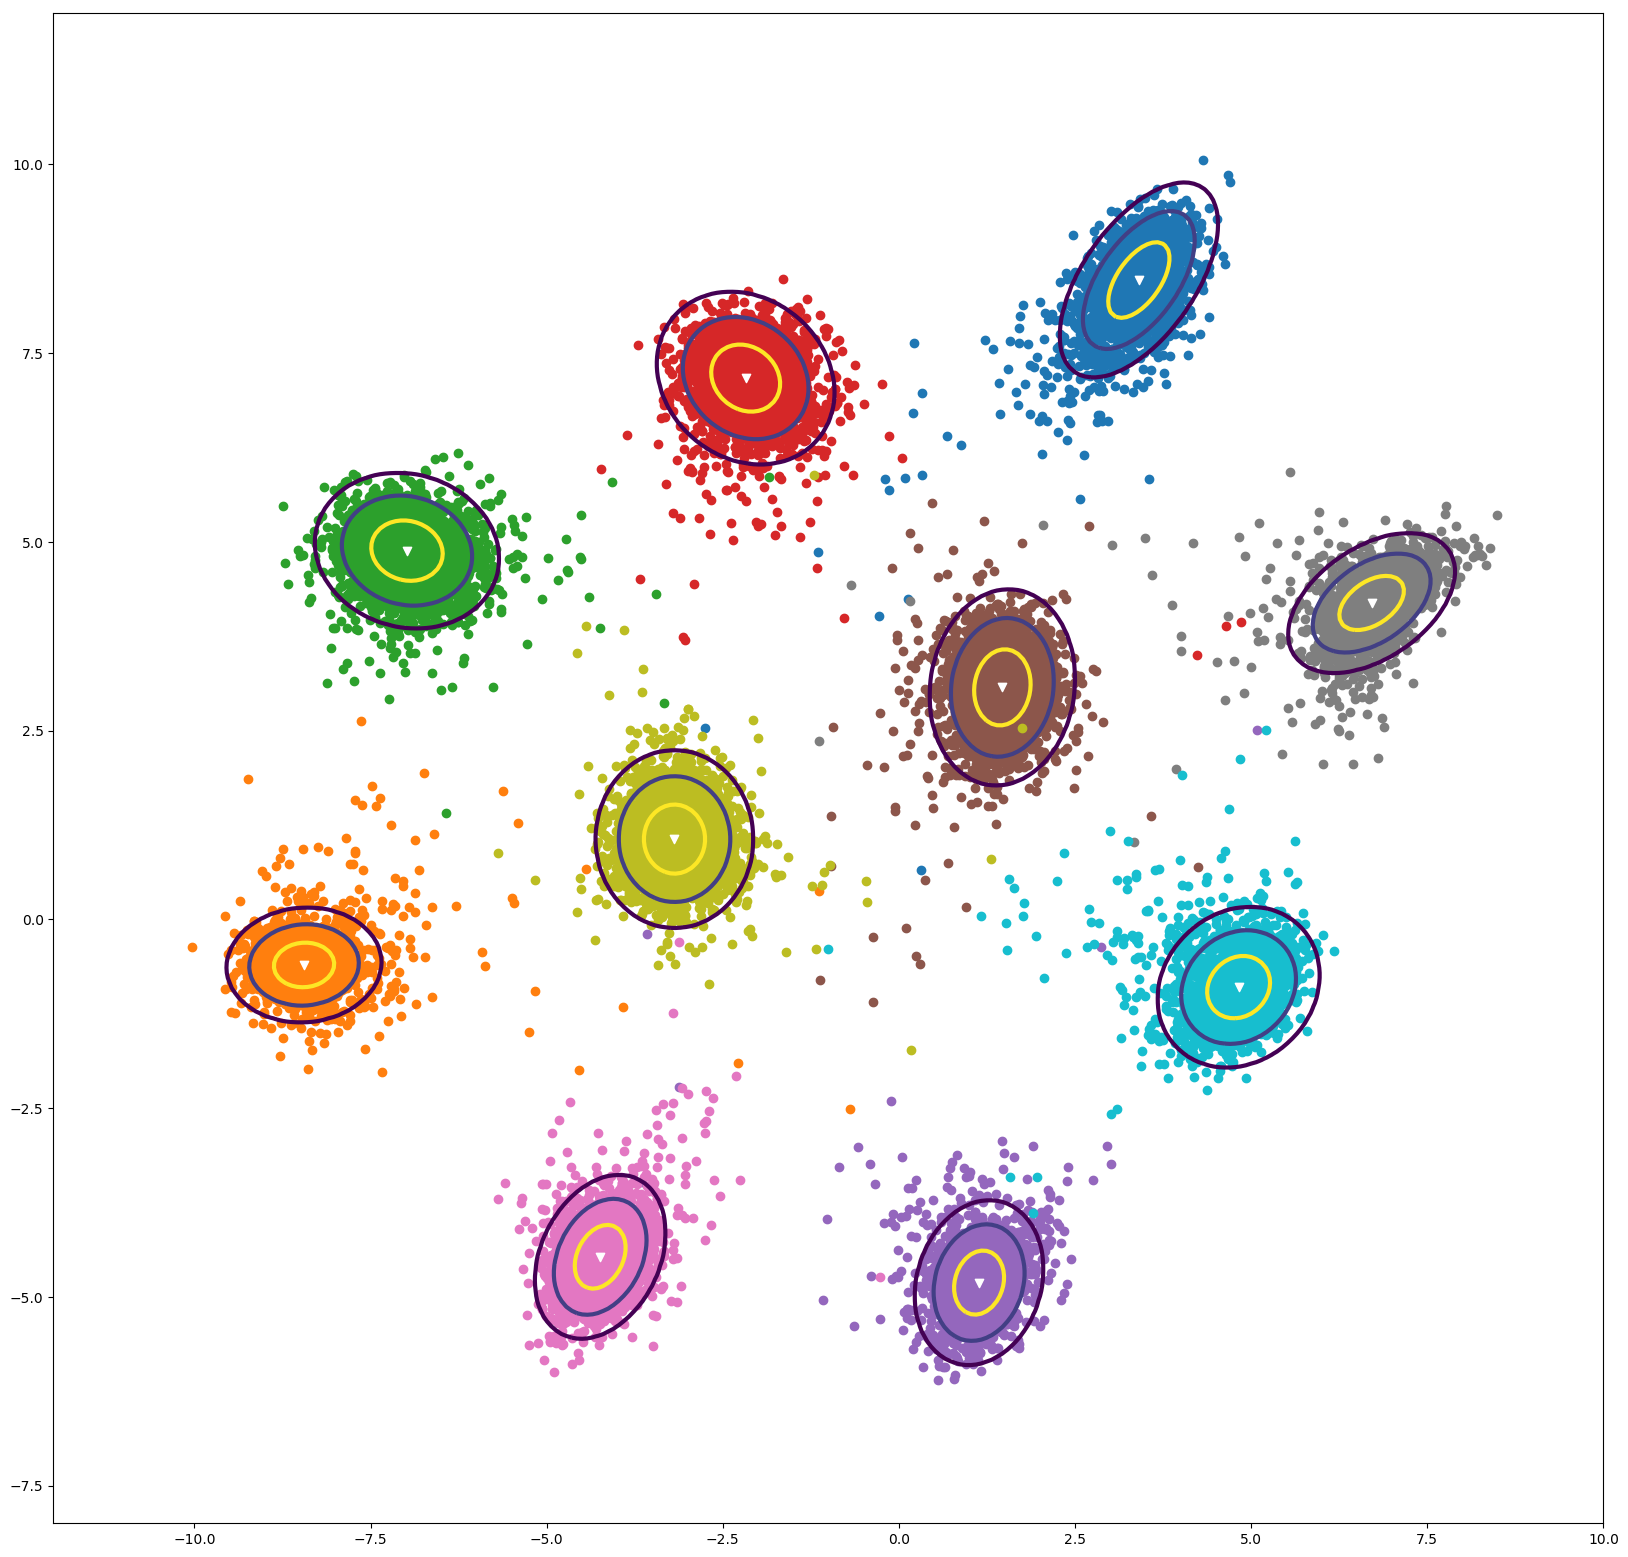

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import percentileofscore

# generate gridpoints
X, Y = np.meshgrid(np.linspace(-12, 10, 300), np.linspace(-8, 12, 300))
xy = np.column_stack([X.flat, Y.flat])
print(xy.shape)

# contour levels
contour_level = [0.01, 0.1, 0.5]

plt.figure(figsize=(20,20), dpi=100)
for i in range(10):
    plt.scatter(embeddings_mnistTrain[:, 0][y_train == i], embeddings_mnistTrain[:, 1][y_train == i])
    
    # density values at the grid points
    Z = multivariate_normal.pdf(xy, params[i]['mean'], params[i]['cov']).reshape(X.shape)
    Z = (Z - Z.min()) / (Z.max() - Z.min())
    
    plt.contour(X, Y, Z, levels=contour_level, linewidths=3)

for i in range(10):
    plt.scatter(params[i]['mean'][0], params[i]['mean'][1], color='white', marker='v')

# plt.savefig('siamese_bivariate_dists')
plt.show()

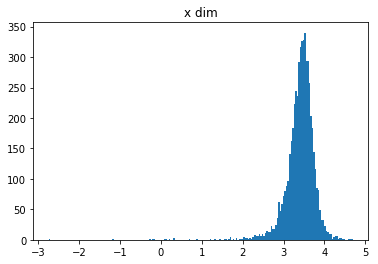

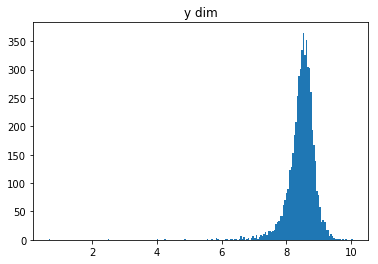

In [18]:
# plotting x, y dimensions of first distribution, does it look normal?
for i in range(1):
    plt.hist(embeddings_mnistTrain[:, 0][y_train == i], bins=200)
    plt.title('x dim')
    plt.show()

    plt.hist(embeddings_mnistTrain[:, 1][y_train == i], bins=200)
    plt.title('y dim')
    plt.show()

# Get test set confidence scores

In [25]:
# mnist_confidences = np.empty((len(embeddings_mnistTest), 10))

# for i, embedding in enumerate(embeddings_mnistTest):
#     confidences = np.empty(10)
#     for k, v in params.items():
#         confidences[k] = multivariate_normal.pdf(embedding, v['mean'], v['cov'])
#     mnist_confidences[i] = confidences
    
# print(mnist_confidences[0])

# for k, v in params.items():
#     mnist_confidences[:, k] = multivariate_normal.pdf(embeddings_mnistTest, v['mean'], v['cov'])   

# print(mnist_confidences[0])
# print(mnist_confidences)

In [26]:
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv

# compute in-distribution distances
mnist_dists = np.empty((len(embeddings_mnistTest), 10))
for i, embedding in enumerate(embeddings_mnistTest):
    dists = np.empty(10)
    for k, v in params.items():
        dists[k] = mahalanobis(v['mean'], embedding, inv(v['cov']))
    mnist_dists[i] = dists

# compute out-of-distribution distances
notMnist_dists = np.empty((len(embeddings_notMnistTest), 10))
for i, embedding in enumerate(embeddings_notMnistTest):
    dists = np.empty(10)
    for k, v in params.items():
        dists[k] = mahalanobis(v['mean'], embedding, inv(v['cov']))
    notMnist_dists[i] = dists

In [39]:
# min
mnist_min_mahal = np.min(mnist_dists, axis=1)
notMnist_min_mahal = np.min(notMnist_dists, axis=1)
print(mnist_min_mahal.shape, notMnist_min_mahal.shape)

# exp-var
mnist_exp_var = np.var(np.exp(mnist_dists), axis=1)
notMnist_exp_var = np.var(np.exp(notMnist_dists), axis=1)
print(mnist_exp_var.shape, notMnist_exp_var.shape)

# var
mnist_var = np.var(mnist_dists, axis=1)
notMnist_var = np.var(notMnist_dists, axis=1)
print(mnist_var.shape, notMnist_var.shape)

(10000,) (10000,)
(10000,) (10000,)
(10000,) (10000,)


# Plot in- vs out- dist histograms

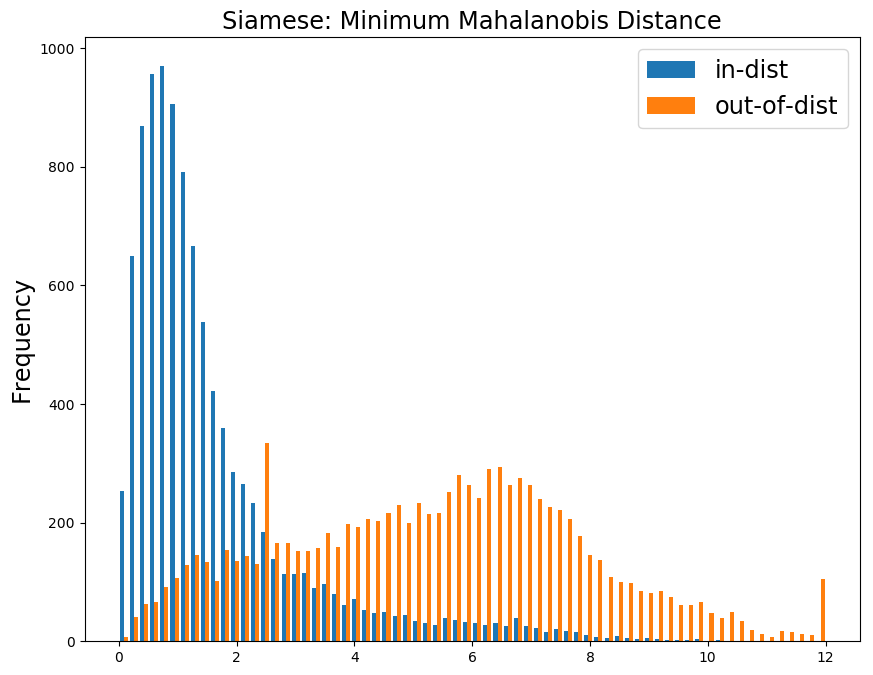

In [38]:
plt.figure(figsize=(10, 8), dpi=100)
plt.title('Siamese: Minimum Mahalanobis Distance', fontsize='xx-large')
plt.hist([np.clip(mnist_min_mahal, None, 12),
          np.clip(notMnist_min_mahal, None, 12)], bins=70, label=['in-dist', 'out-of-dist'])
plt.legend(fontsize='xx-large')
plt.ylabel('Frequency', fontsize='xx-large')
plt.savefig('siamese_min_mahala')
plt.show()

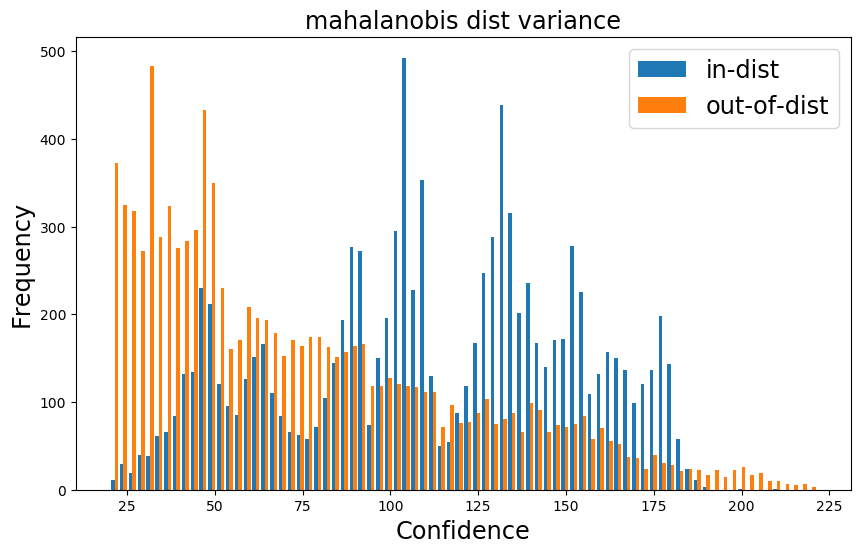

In [37]:
# mahalanobis distances variance
plt.figure(figsize=(10, 6), dpi=100)
plt.title('mahalanobis dist variance', fontsize='xx-large')
plt.hist([mnist_var,
          notMnist_var], bins=80, label=['in-dist', 'out-of-dist'])
plt.legend(fontsize='xx-large')
plt.ylabel('Frequency', fontsize='xx-large')
plt.xlabel('Confidence', fontsize='xx-large')
plt.show()

# Histogram overlap

In [30]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [31]:
# minimum mahalanobis distance
minBin = min(min(mnist_min_mahal),min(notMnist_min_mahal))
maxBin = max(max(mnist_min_mahal),max(notMnist_min_mahal))

hist1, bins1 = np.histogram(mnist_min_mahal, bins=100, range=(minBin, maxBin))
hist2, bins2 = np.histogram(notMnist_min_mahal, bins=100, range=(minBin, maxBin))

return_intersection(hist1, hist2)

0.3342

In [32]:
# mahalanobis distances variance
minBin = min(min(mnist_var), min(notMnist_var))
maxBin = max(max(mnist_var), max(notMnist_var))

hist1, bins1 = np.histogram(mnist_var, bins=100, range=(minBin, maxBin))
hist2, bins2 = np.histogram(notMnist_var, bins=100, range=(minBin, maxBin))

return_intersection(hist1, hist2)

0.56699999999999995

# ROC curve

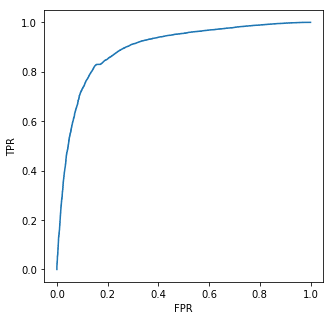

AUROC: 0.89656276


In [34]:
# minimum mahalanobis distance
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = np.concatenate( ( np.ones(len(mnist_min_mahal)), np.zeros(len(notMnist_min_mahal)) ) )
y_score = np.concatenate((-mnist_min_mahal, -notMnist_min_mahal))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_metric = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print('AUROC:', auc_metric)

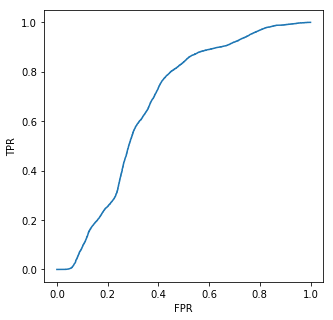

AUROC: 0.67198391


In [35]:
# mahalanobis distances exp-variance
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = np.concatenate( ( np.ones(len(mnist_exp_var)), np.zeros(len(notMnist_exp_var)) ) )
y_score = np.concatenate((mnist_exp_var, notMnist_exp_var))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_metric = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print('AUROC:', auc_metric)

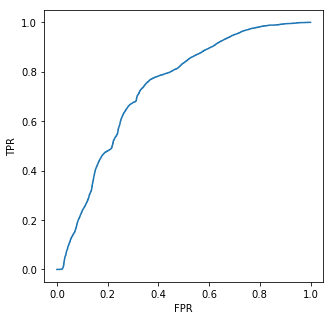

AUROC: 0.73542417


In [40]:
# mahalanobis distances variance
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_true = np.concatenate( ( np.ones(len(mnist_var)), np.zeros(len(notMnist_var)) ) )
y_score = np.concatenate((mnist_var, notMnist_var))
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc_metric = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
print('AUROC:', auc_metric)